# M2177.003100 Deep Learning <br> Assignment #3 Part 2: Image Captioning with RNNs

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Sunyoung Kwon, September 2017

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, <font color=red>**you should use tensorflow RNN libraries**</font> for image captioning of the Microsoft COCO dataset. <br>

For this exercise we will use the 2014 release of the **[Microsoft COCO dataset](http://mscoco.org/)** which has become the standard testbed for image captioning. The dataset consists of about 80,000 images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

The raw images takes up so much (nearly 20GB), we will use the preprocessed COCO datasets which are extracted features from the VGG-16 network and reduced the dimensionality of the features from 4096 to 512 by standford CS231N lecture.

To download the data, change to the `coco/` directory and run the script `get_coco_data.sh`.
- caption and image index: `train2014_captions.h5`
- idx_to_word, word_to_idx: `coco2014_vocab.json`
- extracted and reduced image features: `train2014_vgg16_fc7_pca.h5`
- URLs of the images for visualization: `train2014_urls.txt`
  <br>(Since images are downloaded on-the-fly, **you must be connected to the internet to view images**)

The file `coco_utils.py` has utilities for coco datasets from load COCO data to visualization and evaluation.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all Assignment Part 1, 2 & 3**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Microsoft COCO (http://mscoco.org/dataset/#overview)
- [4] Microsoft COCO Captions (https://arxiv.org/pdf/1504.00325.pdf)
- [5] Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.



## Image Captioning (40 points)

- input : extracted image features from the VGG-16 network<br>
- output: predicted captions<br>
- evaluation: average BLEU scores for validation and independent test dataset
- data: download by run the `./coco/get_coco_data.sh`
- model: save your captiong model in model_path (`./models_captioning`)
- You muse use TensorFlow RNN module (such as tf.contrib.rnn)

Example of image captioning 

<img src="./files/showandtell.png" width=70%>
[Source: "Show and Tell: Lessons learned from the 2015 MSCOCO Image Captioning Challenge."]

## Load libraries
The preprocessed COCO datasets and libraries are loaded.<br>

In [1]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook

data = load_coco_data(base_dir=data_path)
if len(data)==8 : 
    print('COCO data load complete')
   
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

COCO data load complete
train_captions <class 'numpy.ndarray'> (400135, 17) int32
val_captions <class 'numpy.ndarray'> (10000, 17) int32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_image_idxs <class 'numpy.ndarray'> (10000,) int32
features <class 'numpy.ndarray'> (82783, 512) float32
urls <class 'numpy.ndarray'> (82783,) <U63


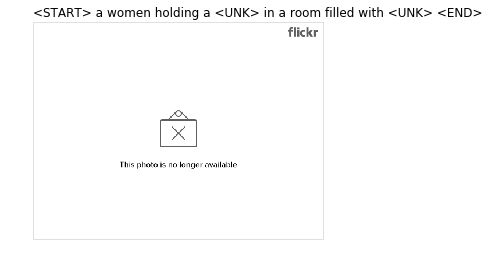

In [3]:
# Sample images and captions
captions, features, urls = sample_coco_minibatch(data, batch_size=1)
show_samples(captions, urls, data)

## Data for training

For simple test, you can load subsample of total train data.<br>
But you should use <font color=red>**full train_data**</font> for final test.<br>
You will be able to verify your captioning model more quickly with the small train data.<br>
<font color=red>**You must show loss changes with full train data**</font> when you train. <br>
And you must show maxlen, n_words, captions.shape.


In [4]:
#-------------------------------------------------------------------------
# CAUTION: Do not change maxlen(17), n_words(1004), input_dimension(512)
# you should use 512 extracted image features
# Do not change coco_utils.py
#-------------------------------------------------------------------------

#----------------------------------------------
# [case 1] subsample
# Try to subsamples of train_data for simple test
#----------------------------------------------
train_data = load_coco_data(base_dir=data_path, max_train=512*100)

#----------------------------------------------
# [case 2] full train data
# Try to full train_data for real test
#----------------------------------------------
train_data = data

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]
input_dimension = train_data['features'].shape[1]


print(n_words)
print(maxlen)
print(img_features.shape, captions.shape)

vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]
print(vimg_features.shape, vcaptions.shape)


1004
17
(400135, 512) (400135, 17)
(10000, 512) (10000, 17)


In [5]:
#################################################################################
# TODO: Implement for caption training class in captioning.py
# you should use TensorFlow RNN libraries (such as tf.contrib.rnn)
# You can modify classes, functions, parameters according to your model structure.
# You can also hide the train function in the Captioning class.
# Just show the loss changes depending on the learning procedure.
#
# class Captioning():
#     def __init(self,...):
#     def model(self,...):
#     def predict(self,...):
#################################################################################

import random

def train(img_features, captions):
    #-------------------------------------------------------------
    # You must show maxlen, n_words, caption.shape !!
    #-------------------------------------------------------------
    print(maxlen, n_words, captions.shape)
    #################################################
    # TODO: Implement caption training
    # - save your trained model in model_path
    # - must print about 10 loss changes !!
    #################################################
    img_feature_dim = img_features.shape[1]
    batch_size = 512
    n_epochs = 23

    conf = tf.ConfigProto()
    conf.gpu_options.per_process_gpu_memory_fraction = 0.2
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

    def calc_caption_length(caption):
        for i, word_idx in enumerate(caption):
            if word_idx == 0:
                return min(len(caption), i+2)
        return len(caption)
    caption_lens = np.array([calc_caption_length(caption) for caption in captions])
    vcaption_lens = np.array([calc_caption_length(caption) for caption in vcaptions])

    known_caption_idxs = np.all(captions != 3, axis=1)

    known_captions = captions[known_caption_idxs]
    known_caption_lens = caption_lens[known_caption_idxs]
    known_img_features = img_features[known_caption_idxs]

    tf.reset_default_graph()

    captioning = Captioning(img_feature_dim, maxlen, n_words, 496, 3)
    input_sequences, input_sequence_lens, input_img_features, \
        loss, optimize, drop_out_keep_rate, teacher_force = captioning.build_model()
    predict_indices = captioning.predict()

    # Saver
    saved_model_path = 'models_captioning/ass3_show_and_tell.ckpt'

    min_valid_loss = 9999.99
    max_BLEU = -1.0
    saver = tf.train.Saver()
    with tf.Session(config=conf) as sess:
        sess.run(tf.global_variables_initializer())

        def generate_minibatch():
            permutation = np.random.permutation(len(known_captions))
            return captions[permutation][:batch_size], \
                caption_lens[permutation][:batch_size], \
                img_features[permutation][:batch_size]

        def generate_minibatch_valid(data_size):
            permutation = np.random.permutation(data_size)
            return vcaptions[permutation][:batch_size], \
                vcaption_lens[permutation][:batch_size], \
                vimg_features[permutation][:batch_size]

        for epoch in range(n_epochs):
            start_time = time.time()
            data_size = captions.shape[0]
            steps = data_size // batch_size

            # train
            loss_sum = 0.0
            for step in range(steps):
                input_seqs, input_seq_lens, input_imgs = generate_minibatch()
                feed_dict = {
                    input_sequences: input_seqs,
                    input_sequence_lens: input_seq_lens,
                    input_img_features: input_imgs,
                    drop_out_keep_rate: 0.1,
                }
                train_loss, _, train_force = sess.run([loss, optimize, teacher_force], feed_dict=feed_dict)
                loss_sum += train_loss

            # validation
            val_loss_sum = 0.0
            val_data_size = vcaptions.shape[0]
            val_steps = val_data_size // batch_size
            for step in range(val_steps):
                input_seqs, input_seq_lens, input_imgs = generate_minibatch_valid(val_data_size)
                feed_dict = {
                    input_sequences: input_seqs,
                    input_sequence_lens: input_seq_lens,
                    input_img_features: input_imgs,
                }      
                val_loss, val_force = sess.run([loss, teacher_force], feed_dict=feed_dict)
                val_loss_sum += val_loss
                
            cur_valid_loss = val_loss_sum / val_steps
            #min_valid_loss = min(min_valid_loss, val_loss_sum / val_steps)

            #print([idx_to_word[idx] for idx in train_force[0]])
            #print([idx_to_word[idx] for idx in val_force[0]])
            # test sentence from validation
            pick_idx = random.randrange(val_data_size)
            feed_dict = {
                input_img_features: np.expand_dims(img_features[pick_idx], axis=0),
            }

            pred_indices = sess.run([predict_indices], feed_dict=feed_dict)
            #print([idx_to_word[idx] for idx in pred_indices[0][0]])
            
            # BLEU score
            def image_captioning(features) :
                pr_captions = np.zeros((features.shape[0],maxlen),int)
                feed_dict = {
                    input_img_features: features,
                }
                predicts = sess.run([predict_indices], feed_dict=feed_dict)
                pr_captions = np.array(predicts[0])
                return pr_captions
            
            def evaluate_model(data, split):
                BLEUscores = {}
                minibatch = sample_coco_minibatch(data, split=split, batch_size="All")
                
                gt_captions, features, urls = minibatch
                gt_captions = decode_captions(gt_captions, data['idx_to_word'])

                pr_captions = image_captioning(features)
                pr_captions = decode_captions(pr_captions, data['idx_to_word'])

                total_score = 0.0

                for gt_caption, pr_caption, url in zip(gt_captions, pr_captions, urls):
                    total_score += BLEU_score(gt_caption, pr_caption)

                BLEUscores[split] = total_score / len(pr_captions)

                return BLEUscores[split]

            #cur_BLEU = evaluate_model(train_data, 'val')
            
            print('epoch {} : '.format(epoch) + ('train loss %.4f, ' % (loss_sum / steps)))

            if cur_valid_loss < min_valid_loss:
                min_valid_loss = cur_valid_loss
                saver.save(sess, saved_model_path)
    
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    
train(img_features, captions) 


17 1004 (400135, 17)
epoch 0 : train loss 3.6545, 
epoch 1 : train loss 2.9784, 
epoch 2 : train loss 2.6874, 
epoch 3 : train loss 2.4680, 
epoch 4 : train loss 2.2961, 
epoch 5 : train loss 2.1690, 
epoch 6 : train loss 2.0872, 
epoch 7 : train loss 2.0351, 
epoch 8 : train loss 2.0030, 
epoch 9 : train loss 1.9792, 
epoch 10 : train loss 1.9613, 
epoch 11 : train loss 1.9476, 
epoch 12 : train loss 1.9357, 
epoch 13 : train loss 1.9255, 
epoch 14 : train loss 1.9176, 
epoch 15 : train loss 1.9115, 
epoch 16 : train loss 1.9056, 
epoch 17 : train loss 1.8992, 
epoch 18 : train loss 1.8883, 
epoch 19 : train loss 1.8876, 
epoch 20 : train loss 1.8827, 
epoch 21 : train loss 1.8780, 
epoch 22 : train loss 1.8757, 


## Evaluation

You can test your model in train, validation samples with sample images.<br>
Final evaluation will be done with average BLEU score.<br>
BLEU (bilingual evaluation understudy) score is between 0 and 1. The values closer to 1 represents more similar texts. <br>
https://en.wikipedia.org/wiki/BLEU
<font color=red>**Your model could be evaluated without traning procedure,**</font> if you saved and loaded your model properly.


In [1]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

train_data = load_coco_data()

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']
vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]


In [2]:
# Write your code for image captioning predicting
# The image_captioning should include following functions
# - load your saved model 
# - return predicted captions from image features

def image_captioning(features) :
    pr_captions = np.zeros((features.shape[0],maxlen),int)
    #################################################
    # TODO: Implement predicting image captioning
    # - load your saved model
    # - predict the captions
    #################################################
    tf.reset_default_graph()
    saved_model_path = 'models_captioning/ass3_show_and_tell.ckpt'
    
    img_feature_dim = features.shape[1]
    
    captioning = Captioning(img_feature_dim, maxlen, n_words, 496, 3)
    input_sequences, input_sequence_lens, input_img_features, \
        loss, optimize, drop_out_keep_rate, teacher_force = captioning.build_model()
    predict_indices = captioning.predict()
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, saved_model_path)
        
        feed_dict = {
            input_img_features: features,
        }

        predicts = sess.run([predict_indices], feed_dict=feed_dict)
        pr_captions = np.array(predicts[0])
    
    #################################################
    #                END OF YOUR CODE               #
    #################################################
    return pr_captions

INFO:tensorflow:Restoring parameters from models_captioning/ass3_show_and_tell.ckpt


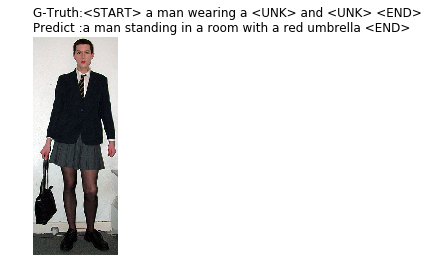

INFO:tensorflow:Restoring parameters from models_captioning/ass3_show_and_tell.ckpt


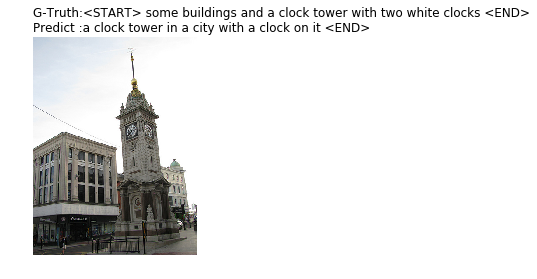

In [3]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(train_data, split=split, batch_size=1)

    gt_captions, features, urls = minibatch
    pr_captions = image_captioning(features)

    show_predict_samples(gt_captions, pr_captions, urls, train_data)

In [4]:
# Prints unigram BLEU score averaged over val dataset

def evaluate_model(data, split):
    BLEUscores = {}

    minibatch = sample_coco_minibatch(data, split=split, batch_size="All")
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    pr_captions = image_captioning(features)
    pr_captions = decode_captions(pr_captions, data['idx_to_word'])

    total_score = 0.0
        
    for gt_caption, pr_caption, url in zip(gt_captions, pr_captions, urls):
        total_score += BLEU_score(gt_caption, pr_caption)

    BLEUscores[split] = total_score / len(pr_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))


In [5]:
evaluate_model(train_data,'val')

Total captions: 10000
INFO:tensorflow:Restoring parameters from models_captioning/ass3_show_and_tell.ckpt
Average BLEU score for val: 0.356162


In [6]:
# This cell is for TA, TA will evaluate your model with independent test_data
# the number of captions of test_data is about 200,000
# you should handle captions up to 200,000

#evaluate_model(test_data,'test')



## Describe what you did here
In this cell you should also write an explanation of what you did.<br>
(A detailed description of your model, structure, tensorflow module and others)
<font color=red>**You must describe your model**</font>

### Input embedding
<p>
    We compared models with<br>
    - Embedding variable with L2 loss<br>
    - Embedding variable with softmax and cross entropy<br>
    - One-hot encoding with sotfmax and cross entopy<br>
    One-hot encoding with n_words dimension converged well.
</p>

### RNN
<p>
    We use the LSTM cell provided in the tensorflow library. After the parameter experiments, we conclude that hidden size of 496 with 3 multi-layered RNN structure perfoms best. We initialize the hidden state of rnn cell with the image features given by the TL. And cell is initialized with zero vector. All of layers have the same initialization. We choose the dynamic_rnn funtion to improve efficiency of the model by utilizing the given the length of sequences to restrict training about extra padding sequences.
</p>

### Training
<p>
    When we train the model, we permutate captions at every minibatch to improve performance in aspect to generalization. By choosing complex model with high dropout rate, we feed enough datas via hugh epochs which make our model have enough capacity and generality at the same time. We keep track the validation loss and BLEU scores for each epoch to decide early stop point and save the best model during the training phase.
</p>

### Optimization
<p>
    When training phase, we choose the teacher forcing technics to improce training rates. Adam optimizer with the fixed learning rate 1e-3 is selected. We didn't try decaying learning rate because we did early stop by tracking the BLEU scores.
</p>

### Conclusion
<p>
    Softmax with cross entropy loss is very powerful!
</p>